<a href="https://colab.research.google.com/github/antonFJohansson/FFA_wasp/blob/master/Langevin_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

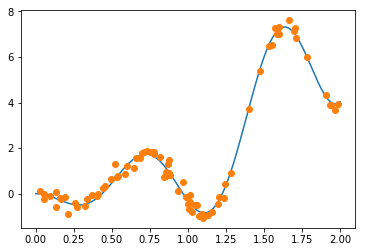

In [9]:
### For Neural network here

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data


## Generate the data
x = np.arange(0,2,0.001)
y = x**3 - x*2*np.sin(7*x) 
plt.plot(x,y)

noise_std = 0.2
N = 80 ## Had 60
x_data = np.random.uniform(0,2,N)
y_data = x_data**3 - x_data*2*np.sin(7*x_data) + np.random.normal(0, noise_std, N)
plt.plot(x_data,y_data, linewidth = 0, marker = 'o')

x_t = torch.from_numpy(x_data).view(N,1).float()
y_t = torch.from_numpy(y_data).view(N,1).float()

data_vec = torch.cat((x_t,y_t), 1)
mini_batch_size = 40


train_loader = torch.utils.data.DataLoader(data_vec, batch_size = mini_batch_size, shuffle = True)

In [10]:
import torch.nn.functional as F

class Network(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(1,50)
    self.fc2 = nn.Linear(50,50)
    self.fc3 = nn.Linear(50,50)
    self.fc4 = nn.Linear(50, 1)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

max_epoch = 20000

def lr_sched(t, max_epoch = max_epoch):
  
  k = (0.0000001-0.00005) / (max_epoch - 1)
  m = 0.00005-k*1
  step=k*t+m
  
  return step

  
torch.manual_seed(0)
np.random.seed(2)
  
my_net = Network()
loss_fn = nn.MSELoss()



def l2_loss(network):
  
  tot_loss = 0
  
  for param in network.parameters():
    tot_loss = tot_loss + (param**2).sum()
  return tot_loss


x_plot = np.arange(-2,4,0.01)
x_plot_t = torch.from_numpy(x_plot).view(x_plot.shape[0],1).float()
store_results = torch.zeros(max_epoch - int(0.9*max_epoch), x_plot.shape[0])
indk = 0

for epoch in range(max_epoch):
  
  for data in train_loader:
    
    my_net.zero_grad()
    x_val = data[:,0].view(mini_batch_size, 1)
    y_val = data[:,1].view(mini_batch_size, 1)
    
    
    out = my_net(x_val)
    loss = N*loss_fn(out, y_val) + 5e-4*l2_loss(my_net)#N*loss_fn(out, y_val) + 5e-4*l2_loss(my_net)
    loss.backward()
    
    lr = lr_sched(epoch) ## Might change later to each iteration
    for param in my_net.parameters():
      param.data = param.data - lr/2 * param.grad.data - torch.Tensor(param.data.shape).normal_(0,np.sqrt(lr))
      
  ## Save last 10% of samples as posterior samples
  if epoch > int(0.9*max_epoch):
      with torch.no_grad():
        
        out_plot = my_net(x_plot_t).detach()
        store_results[indk,:] = out_plot[:,0]
        indk +=1
      
  
  if epoch % (max_epoch / 10) == 0 or epoch == max_epoch -1:
    print('Epoch {} Train Loss {:.2f} lr {:.7f}'.format(epoch, loss.item(), lr))



Epoch 0 Train Loss 541.24 lr 0.0000500
Epoch 2000 Train Loss 23.21 lr 0.0000450
Epoch 4000 Train Loss 13.13 lr 0.0000400
Epoch 6000 Train Loss 41.85 lr 0.0000350
Epoch 8000 Train Loss 37.41 lr 0.0000300
Epoch 10000 Train Loss 15.70 lr 0.0000251
Epoch 12000 Train Loss 39.23 lr 0.0000201
Epoch 14000 Train Loss 16.55 lr 0.0000151
Epoch 16000 Train Loss 14.35 lr 0.0000101
Epoch 18000 Train Loss 12.80 lr 0.0000051
Epoch 19999 Train Loss 18.59 lr 0.0000001


No handles with labels found to put in legend.


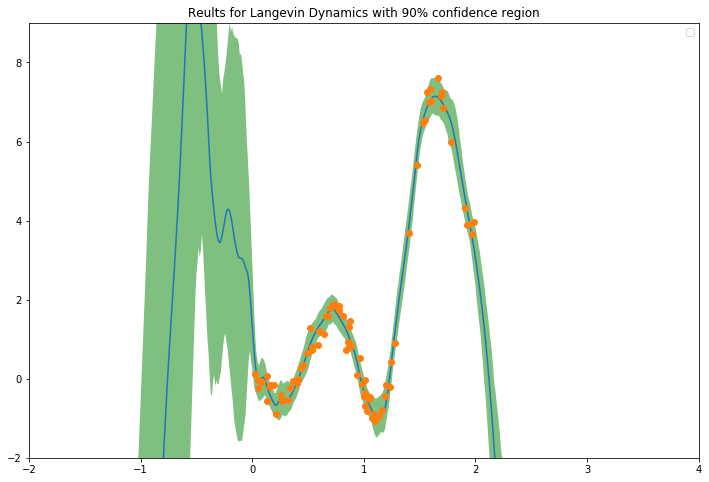

In [16]:
## Take out a subsample of the last 10% of samples to avoid correlation
row_ind = [k for k in range(max_epoch - int(0.9*max_epoch)) if k % 10 == 0]
store_resultss = store_results[row_ind,:]
out_numpy = store_resultss.numpy()

## mean, upper boundary, lower boundary
out_mean = np.mean(out_numpy, 0)
out_uq = np.quantile(out_numpy, 0.95, 0)
out_lq = np.quantile(out_numpy, 0.05, 0)


fig, ax = plt.subplots()
ax.plot(x_plot,out_mean)
ax.fill_between(x_plot, out_lq, out_uq, facecolor='green', alpha=0.5)
#ax.plot(x_plot,out_uq)
#ax.plot(x_plot,out_lq)

ax.plot(x_data,y_data, linewidth = 0, marker = 'o')
ax.set_xlim(-2, 4)
ax.set_ylim(-2, 9)
ax.set_title('Reults for Langevin Dynamics with 90% confidence region')
fig.set_size_inches(12, 8, forward=True)
ax.legend()